# Daisyworld model using Campo

## Overview and introduction

DaisyWorld was introduced by James Lovelock and Andrew Watson (1983), to
illustrate the Gaia Hypothesis that organisms can create a
self-regulating system by interacting with their surroundings.

In Daisyworld, only two life forms (agents) are present: black daisies
and white daisies. White daisies have a high albedo, reflecting light,
thereby cooling the surface temperature (a field). In contrast, black
daisies have a low albedo, absorbing light, thereby increasing the
surface temperature.

Daisies can only reproduce in a certain temperature range; this is where
the interaction between the organisms (agents) and their surroundings
(field) occurs. As you will see when running the model, this leads to an
equilibrium between black and white daisies under a relatively wide
range of luminosity conditions.

## Representing the Daisyworld model in Campo

For the Daisyworld model, we represent the daisies and the climate with
two different phenomena. The daisies and the climate will be represented
according to the following scheme: 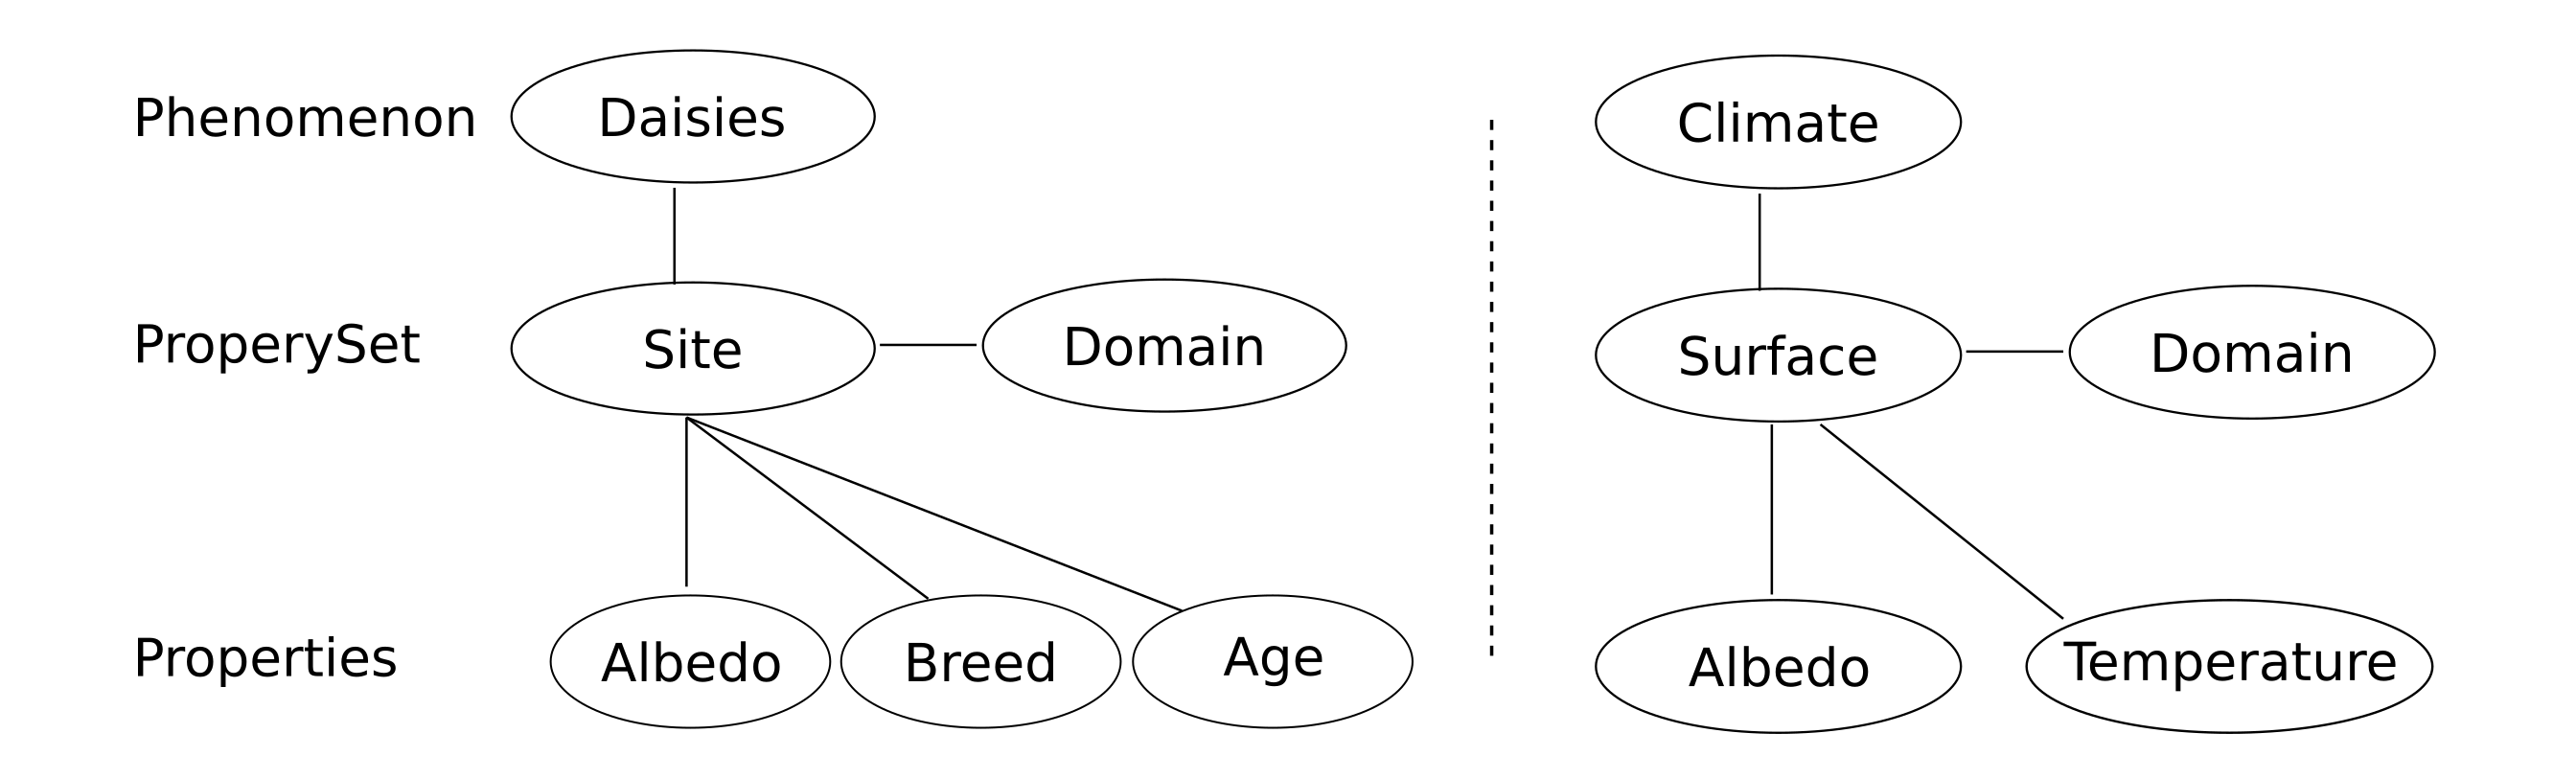

Daisies will use point coordinates as their spatial domain, the spatial
domain of the climate will be represented by a bounding box and a number
of rows and columns. The property values of both can change over time.

### Instantiation of daisies and surface temperature

To add phenomena to a model it is first required to initialise a model
data object:

``` python
  daisy_world = campo.Campo()
```

The `daisy_world` object will provide access to the methods for
constructing agents, and eventually arrange the storage to the LUE
dataset on disk.

Now the phenomena can be added:

``` python
  daisies = daisy_world.add_phenomenon('daisies')
  climate = daisy_world.add_phenomenon('climate')
```

This will add empty phenomena with zero agents to a model. The type of
an agent is defined by its spatial domain obtained from an input file.
The input data will also set the number of agents:

``` python
  daisies.add_property_set('site', 'location_site.csv')
  climate.add_property_set('surface', 'area_extent.csv')
```

Properties can then be assigned and initialised using the dot notation:

``` python
  daisies.site.age = 0
  climate.surface.albedo = 0.4
```

### Operations on field or agent properties

Campo resembles and extends the map algebra approach to field-agent
modelling, thereby providing operations accepting both fields or agents
as arguments. Arithmetic operations (+, -, /, \*) and comparisons
(e.g. \<, \>=) can be directly used with properties, they are overloaded
operators and are executed for each object in a property. E.g.
increasing the daisie’s age and the surface temperature by one can be
done as follows:

``` python
  daisies.site.age = daisies.site.age + 1
  climate.surface.temperature = climate.surface.temperature + 1
```

Other operations on properties are provided by the `campo` module, such
as the `uniform()` operation:

``` python
  daisies.site.age = campo.uniform(daisies.site.low, daisies.site.up)
  climate.surface.temperature = campo.uniform(climate.surface.low, climate.surface.up)
```

More information on the operations included in the `campo` module can be
found at
https://campo.computationalgeography.org/documentation/index.html.

## Running the Daisyworld model

### Setting up the environment

First import Campo and additional required Python modules to run this
notebook.

In [ ]:
import datetime
import enum

from osgeo import gdal, ogr, osr

import pcraster as pcr
import pcraster.framework as pcrfw

import campo
import utils

### Generating the input files

For initialisation of the model we will create two input files, one file
holding the locations of the daisies as x,y coordinate pair, and a
second file describing the extent and discretisation of the area. The
extent will be used for the climate’s temperature and albedo fields, and
each raster cell in the area will hold one daisy.

The input files will be generated when executing the following code
cell. Create e.g. a raster with 10 rows and columns:

In [ ]:
utils.generate_input_files(rows=10, cols=10)

To obtain reproducible results we fix the random seed. You can set the
seed to 0 to get different results each model run.

In [ ]:
seed = 1
pcr.setrandomseed(seed)

### Model scenarios

The model can be run for different scenarios, which reflect different
luminosity conditions. The `our` scenario reflects our current
luminosity conditions. The scenarios `low` and `high` have relatively
low and high luminosity, respectively, compared to current conditions.
In the `ramp` scenario, the luminosity increases and then decreases over
800 time steps. You will later specify the scenario as input to the
model.

In [ ]:
class Scenarios(enum.Enum):
    low = 1
    high = 2
    our = 3
    ramp = 4

### Implementation of the Daisyworld model

In [ ]:
class DaisyWorld(pcrfw.DynamicModel):
    def __init__(self, fraction_white=0.2, fraction_black=0.2, albedo_white=0.75, albedo_black=0.25, surface_albedo=0.4, scenario=Scenarios.our):
        pcrfw.DynamicModel.__init__(self)
        # Framework requires a clone
        # set a dummy
        pcr.setclone(5, 4, 10, 0, 0)
        self.fraction_white = fraction_white / 100
        self.fraction_black = fraction_black / 100
        self.albedo_white = albedo_white
        self.albedo_black = albedo_black
        self.surface_albedo = surface_albedo
        self.scenario = scenario

        # Simple input checking...
        assert self.fraction_white >= 0 and self.fraction_white <= 1, 'fraction_white should be between 0 and 100'
        assert self.fraction_black >= 0 and self.fraction_black <= 1, 'fraction_black should be between 0 and 100'

        assert self.albedo_white >= 0 and self.albedo_white <= 1, 'albedo_white should be between 0 and 1'
        assert self.albedo_black >= 0 and self.albedo_black <= 1, 'albedo_black should be between 0 and 1'

        assert self.surface_albedo >= 0, 'surface_albedo should be larger than 0'

    def initial(self):
        self.daisy_world = campo.Campo()

        # Daisies

        self.daisies = self.daisy_world.add_phenomenon('daisies')

        self.daisies.add_property_set('site', 'location_daisies.csv')

        # default init all agents
        self.daisies.site.age_min = 0
        self.daisies.site.age_max = 25
        self.daisies.site.age = self.daisies.site.age_min

        self.daisies.site.albedo_init = 1
        self.daisies.site.breed = -1
        self.daisies.site.albedo = self.daisies.site.albedo_init

        self.daisies.site.mask_dead = -1
        self.daisies.site.mask_alive = 1
        self.daisies.site.mask = self.daisies.site.mask_dead

        self.daisies.site.lower = 0
        self.daisies.site.upper = 1
        self.daisies.site.init = campo.uniform(
            self.daisies.site.lower, self.daisies.site.upper, seed)

        self.daisies.site.w_value = 0
        self.daisies.site.b_value = 1
        self.daisies.site.albedo_white = self.albedo_white
        self.daisies.site.albedo_black = self.albedo_black

        # cover of the world surface of breeds
        self.daisies.site.whites = self.fraction_white
        self.daisies.site.blacks = 1 - self.fraction_black
        self.daisies.site.breed = campo.where(
            self.daisies.site.init < self.daisies.site.whites, self.daisies.site.w_value, self.daisies.site.breed)
        self.daisies.site.breed = campo.where(
            self.daisies.site.init > self.daisies.site.blacks, self.daisies.site.b_value, self.daisies.site.breed)

        self.daisies.site.albedo = campo.where(
            self.daisies.site.init < self.daisies.site.whites, self.daisies.site.albedo_white, self.daisies.site.albedo)
        self.daisies.site.albedo = campo.where(
            self.daisies.site.init > self.daisies.site.blacks, self.daisies.site.albedo_black, self.daisies.site.albedo)

        self.daisies.site.age_init = campo.random_integers(
            self.daisies.site.age_min, self.daisies.site.age_max, seed)
        self.daisies.site.age = campo.where(
            self.daisies.site.init < self.daisies.site.whites, self.daisies.site.age_init, self.daisies.site.age)
        self.daisies.site.age = campo.where(
            self.daisies.site.init > self.daisies.site.blacks, self.daisies.site.age_init, self.daisies.site.age)

        # reuse b_value for mask, -1: dead, 1: alive
        self.daisies.site.mask = campo.where(
            self.daisies.site.init < self.daisies.site.whites, self.daisies.site.b_value, self.daisies.site.mask)
        self.daisies.site.mask = campo.where(
            self.daisies.site.init > self.daisies.site.blacks, self.daisies.site.b_value, self.daisies.site.mask)

        self.daisies.site.init_breed = self.daisies.site.breed
        self.daisies.site.init_mask = self.daisies.site.mask

        self.daisies.site.buffersize = 15
        self.daisies.site.neighbours = campo.get_others(
            self.daisies.site, self.daisies.site, self.daisies.site.buffersize)

        # technical detail
        self.daisies.set_epsg(28992)

        # Temperature field
        self.climate = self.daisy_world.add_phenomenon('climate')
        self.climate.add_property_set('surface', 'area_extent.csv')

        self.climate.set_epsg(28992)
        self.climate.surface.temperature = 0
        self.climate.surface.surface_albedo = self.surface_albedo
        self.climate.surface.zeros = 0
        self.climate.surface.ones = 1
        self.climate.surface.window_size = 30
        self.climate.surface.default_local_heating = 80
        self.climate.surface.fraction = 1 / (campo.windowtotal(self.climate.surface.ones,
                                          self.climate.surface.window_size) - 1)

        if self.scenario == Scenarios.low:
            self.climate.surface.solar_luminosity = 0.6
        elif self.scenario == Scenarios.high:
            self.climate.surface.solar_luminosity = 1.4
        elif self.scenario == Scenarios.our:
            self.climate.surface.solar_luminosity = 1.0
        elif self.scenario == Scenarios.ramp:
            self.climate.surface.solar_luminosity = 0.8

        self.suface_temperature()
        self.climate.surface.init_temp = self.climate.surface.temperature

        # create the output lue data set
        self.daisy_world.create_dataset("daisy_world.lue")

        # create real time settings for lue
        date = datetime.date(2000, 1, 1)
        time = datetime.time(0, 0)
        start = datetime.datetime.combine(date, time)
        unit = campo.TimeUnit.month
        stepsize = 1
        self.daisy_world.set_time(start, unit, stepsize, self.nrTimeSteps())

        # technical detail to inform lue properties may change over time
        self.daisies.site.mask.is_dynamic = True
        self.daisies.site.age.is_dynamic = True
        self.daisies.site.albedo.is_dynamic = True
        self.daisies.site.breed.is_dynamic = True
        self.climate.surface.temperature.is_dynamic = True
        self.climate.surface.solar_luminosity.is_dynamic = True

        # write initial data to disk
        self.daisy_world.write()

    def suface_temperature(self):
        surface_albedo = (1 - self.climate.surface.surface_albedo) * \
            self.climate.surface.solar_luminosity

        d_albedo = campo.feature_values_to_raster(
            self.climate.surface, self.daisies.site, self.daisies.site.albedo)
        daisy_albedo = (1 - d_albedo) * self.climate.surface.solar_luminosity

        condition = campo.feature_values_to_raster(
            self.climate.surface, self.daisies.site, self.daisies.site.mask) == 1
        absorbed_luminosity = campo.where(
            condition, daisy_albedo, surface_albedo)

        local_heating = campo.where(absorbed_luminosity > 0,
                                    72 * campo.log(absorbed_luminosity) + 80,
                                    self.climate.surface.default_local_heating)

        self.climate.surface.temperature = (
            self.climate.surface.temperature + local_heating) / 2.0

    def diffuse_temperature(self, ratio=0.5):
        condition = campo.feature_values_to_raster(
            self.climate.surface, self.daisies.site, self.daisies.site.mask) == 1
        spread = campo.spread(
            condition, self.climate.surface.zeros, self.climate.surface.ones) < 15

        # Sum of temperatures neighbours, exclude yourself
        temp_neighbours = campo.windowtotal(
            self.climate.surface.temperature, self.climate.surface.window_size) - self.climate.surface.temperature
        temp_neighbours = campo.where(
            spread, temp_neighbours, self.climate.surface.zeros)

        self.climate.surface.temperature = (
            1 - ratio) * self.climate.surface.temperature + temp_neighbours * self.climate.surface.fraction * ratio

    def solar_activity(self, timestep):
        if self.scenario == Scenarios.ramp:
            if timestep > 200 and timestep <= 400:
                self.climate.surface.solar_luminosity += 0.005

            if timestep > 500 and timestep <= 750:
                self.climate.surface.solar_luminosity -= 0.0025

    def spread_plants(self):
        seed_threshold = 0.1457 * self.climate.surface.temperature - \
            0.0032 * self.climate.surface.temperature**2 - 0.6443

        self.daisies.site.init = campo.uniform(
            self.daisies.site.lower, self.daisies.site.upper, seed)

        campo.spread_neighbours(self.daisies.site.neighbours, seed_threshold, self.daisies.site.init,
                                self.daisies.site.breed, self.daisies.site.mask, self.daisies.site.albedo, self.daisies.site.age, seed)

    def dynamic(self):
        # Processes executed per time step
        self.suface_temperature()
        self.diffuse_temperature()
        self.spread_plants()
        self.solar_activity(self.currentTimeStep())

        # Increase age of daisies
        self.daisies.site.age = campo.where(campo.logical_and(self.daisies.site.age <= self.daisies.site.age_max,
                                                                self.daisies.site.mask == 1), self.daisies.site.age + 1, self.daisies.site.age_min)

        # Reset mask and albedo for dead plants
        self.daisies.site.mask = campo.where(
            (self.daisies.site.age > self.daisies.site.age_max), self.daisies.site.mask_dead, self.daisies.site.mask)
        self.daisies.site.albedo = campo.where(
            self.daisies.site.mask == 1, self.daisies.site.albedo, self.daisies.site.albedo_init)

        # Write data for current time step to disk
        self.daisy_world.write(self.currentTimeStep())

### Running the model

You can run the model with default parameter settings, or adapt those to
your own needs. Start e.g. with running the four different scenarios.
800 time steps are recommended for the `ramp` scenario, other scenarios
can use fewer time steps.

When the model is running you will see some `.` indicating the progress
over time steps.

In [ ]:
# This might need a moment to complete
if __name__ == '__main__':
    # Time steps  to run
    timesteps = 150
    # Initial fractions of daisy breeds, 0 - 100
    fraction_white = 20
    fraction_black = 20
    # Fraction of daisy albledos, 0 - 1
    albedo_white = 0.75
    albedo_black = 0.25
    # Albedo of the area
    surface_albedo = 0.4
    # Scenatio to run, see above
    scenario = Scenarios.our

    myModel = DaisyWorld(fraction_white, fraction_black, albedo_white, albedo_black, surface_albedo, scenario)
    dynFrw = pcrfw.DynamicFramework(myModel, timesteps)
    dynFrw.run()

## Model ouput

During model run data is written for each time step to the
`daisy_world.lue` output file. This dataset can be used to create
animations and time series plots.

You can visualize your input luminosity over time with:

In [ ]:
utils.plot_luminosity()

To evaluate the resulting spatio-temporal pattern of daisies and the
surface temperature you can animate those with:

In [ ]:
# This might need a moment to complete
utils.animate()

The resulting average surface temperature over time can be plotted with:

In [ ]:
utils.plot_temperature()

The total sizes of the black and white daisy populations over time can
be plotted with:

In [ ]:
utils.plot_population()